In [3]:
import pandas as pd
url = "https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/export/format=xlsx"

file = pd.ExcelFile(url)
#Define a dictionary which assigns the cities from the database to countries
cities =	{
    "barcelona" : "spain",
    "budapest" : "hungary",
    "lisbon" : "portugal",
    "london" : "united_kingdom",
    "paris" : "france",
    "rome" : "italy",
    "vienna" : "austria",
    "amsterdam": "netherlands",
    "athens": "greece",
    "berlin": "germany",
}
#Create list of dataframes
dfs = []
#Assign sheets from the excel file to the dataframe list
for sheet_name in file.sheet_names:
    df = file.parse(sheet_name)
    #Assign values to new "city" and "country" column depending on the excel file"s sheet names
    for key in cities:
        if key in sheet_name:
            df["city"] = key
            df["country"] = cities[key]
    #Create weekends/weekdays column depending on the sheet name
    if "weekdays" in sheet_name:
        df["week_category"] = "weekdays"
    elif "weekends" in sheet_name:
        df["week_category"] = "weekends"
    dfs.append(df)
#Create a single dataframe out of the list
df = pd.concat(dfs, ignore_index=True)
#Remove the first column
df = df.iloc[: , 1:]
#Rename column "realSum" to "price"
df = df.rename(columns={"realSum": "price"})
#For joining the columns of room_shared and room_private, we need three categories, as there are airbnbs in which both values are False
#This functions returns a value for the new column depending on the values from the previous columns
def room_sharing_check(row):
    if row["room_shared"] == True and row["room_private"]== False:
        return "room_shared"
    if row["room_shared"] == False and row["room_private"]== True:
        return "room_private"
    else:
        return "no_indication"
#Creates new column, values are determined by function "room_sharing_check"
df["room_privacy"] = df.apply(room_sharing_check, axis=1)
#Drop the columns "room_shared" and "room_private"
df = df.drop(["room_shared", "room_private"], axis=1)
def listing_check(row):
    if row["multi"] == 0 and row["biz"] == 0:
        return "1"
    if row["multi"] == 1 and row["biz"] == 0:
        return "2-4"
    if row["multi"] == 0 and row["biz"] == 1:
        return "more_than_4"
    else:
        return "no_indication"
df["listings"] = df.apply(listing_check, axis=1)
df = df.drop(["multi","biz"], axis=1)

In [ ]:
#Find out how many listings there are in this city
city_counts = df["city"].value_counts()
print(city_counts)

In [ ]:
#Find out the proportions of superhosts 
city_superhost_proportions = df.groupby("city").apply(
    lambda x: (x["host_is_superhost"].sum() / len(x))
).reset_index(name="superhost_proportion")
print(city_superhost_proportions)

In [ ]:
#Cities which contain appartments with more than four rooms
where_appartments_with_more_than_four_rooms_are = df[df["bedrooms"] > 4]["city"].unique()
print(where_appartments_with_more_than_four_rooms_are)

In [ ]:
#Cities with the most entire home/apt-listings
count_per_city = df[df["room_type"] == "Entire home/apt"].groupby("city").size()
print(count_per_city.idxmax())
print(count_per_city.max())

In [ ]:
#Find out whether ratings are usually high
print(df['guest_satisfaction_overall'].mean())
fig, ax = plt.subplots()

ax.hist(df["guest_satisfaction_overall"])

In [ ]:
#Find out how cleanliness ratings are distributed
print(df["cleanliness_rating"].mean())
fig, ax = plt.subplots()
ax.hist(df["cleanliness_rating"])

In [ ]:
#Find out how prices are distributed
we_df = df[df["week_category"] == "weekends"]
wd_df = df[df["week_category"] == "weekdays"]
fig, axes = plt.subplots(1, 2)

we_df["price"].hist(ax = axes[0])
axes[0].set_yscale("log")

wd_df["price"].hist(ax = axes[1])
axes[1].set_yscale("log")

In [ ]:
#Testing questions 1- 7
#1 - Examine three city pairs for price differences on weekdays
def cityPriceComparison(city1, city2):
    wd_df = df[df["week_category"] == "weekdays"]
    city_df = wd_df[wd_df["city"] == city1]
    print(city1 + ":")
    print(city_df["price"].mean())
    city_df = wd_df[wd_df["city"] == city2]
    print(city2 + ":")
    print(city_df["price"].mean())
#Amsterdam and Berlin
cityPriceComparison("amsterdam", "berlin")
#Rome and Barcelona
cityPriceComparison("rome", "barcelona")
#London and Budapest
cityPriceComparison("london", "budapest")
#2 - Compare average weekend and weekday prices
print(f"Mean price on weekend: {we_df["price"].mean()}")
print(f"Mean price on weekday: {wd_df["price"].mean()}")
print(f"Difference: {we_df["price"].mean() - wd_df["price"].mean()}")
#3 - Are listings of superhosts more expensive than those of normal hosts?
sh_df = df[df["host_is_superhost"] == True]
nh_df = df[df["host_is_superhost"] == False]
print(f"Mean price with superhost: {sh_df["price"].mean()}")
print(f"Mean price without superhost: {nh_df["price"].mean()}")
print(f"Difference: {sh_df["price"].mean() - nh_df["price"].mean()}")
#4 - Are superhosts closer to the city center and to the next metro station than normal hosts?
#City center
print(f"Mean distance to center with superhost: {sh_df["dist"].mean()}")
print(f"Mean distance to center without superhost: {nh_df["dist"].mean()}")
print(f"Difference: {sh_df["dist"].mean() - nh_df["dist"].mean()}")
#Metro station
print(f"Mean distance to metro with superhost: {sh_df["metro_dist"].mean()}")
print(f"Mean distance to metro without superhost: {nh_df["metro_dist"].mean()}")
print(f"Difference: {sh_df["metro_dist"].mean() - nh_df["metro_dist"].mean()}")
#5 - Are superhosts cleaner than normal hosts?
print(f"Mean cleanliness rating of superhosts: {sh_df["cleanliness_rating"].mean()}")
print(f"Mean cleanliness rating of normal hosts: {nh_df["cleanliness_rating"].mean()}")
print(f"Difference: {sh_df["cleanliness_rating"].mean() - nh_df["cleanliness_rating"].mean()}")
#6 - Is there a pattern between room types and superhost status?
print(f"Superhosts: {sh_df["room_type"].value_counts()}")
print(f"Normal hosts: {nh_df["room_type"].value_counts()}")
#7 - Is renting an entire home/apt more expensive than a private room? Does that depend on the city?
import seaborn as sns
avg_price = df.groupby(['city', 'room_type'])['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_price, x='city', y='price', hue='room_type')
# Add labels and title
plt.title('Average Price by Room Type and City')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.legend(title='Room Type')
plt.show()

In [5]:
#8 - Maps of the cities - additional libraries needed
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as cx
#Transform dataframe to GeoDataFrame
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lng, df.lat), crs="EPSG:4258"
)

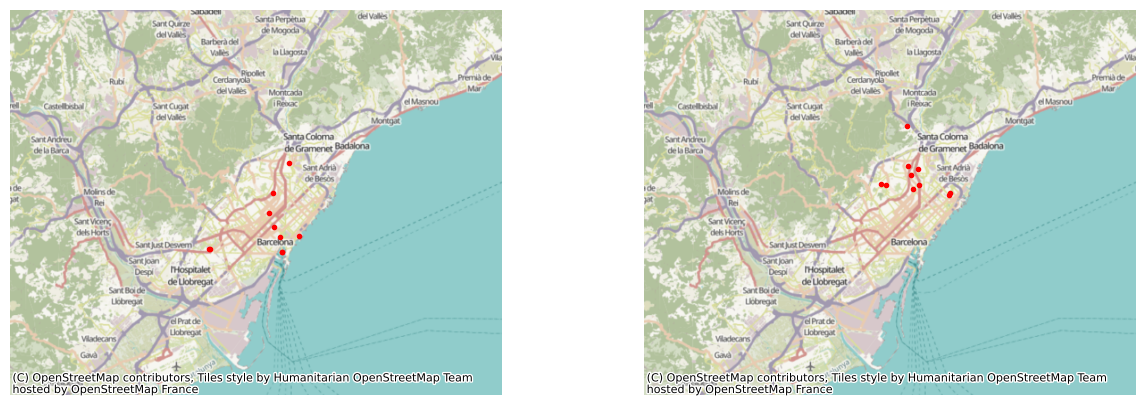

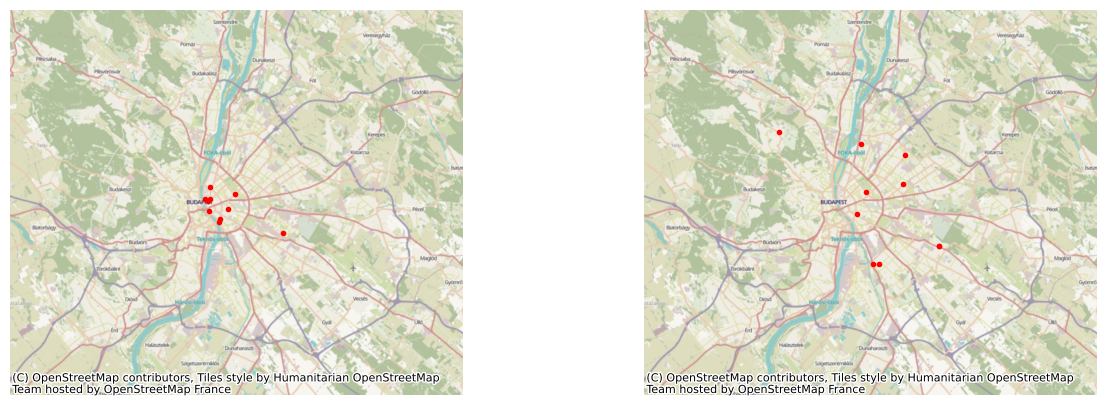

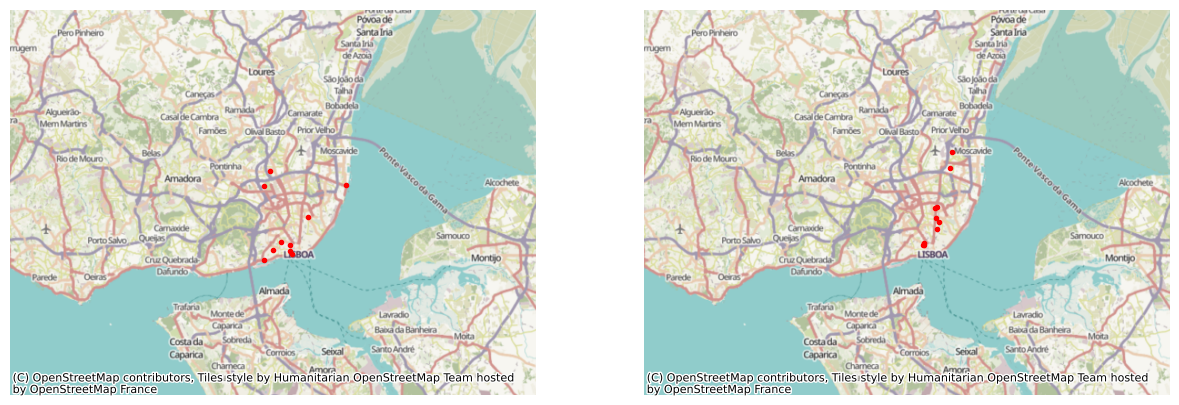

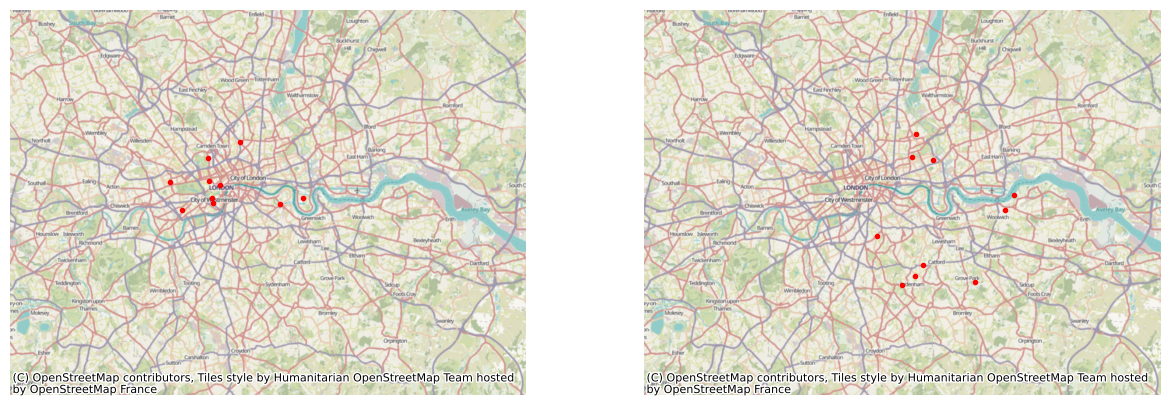

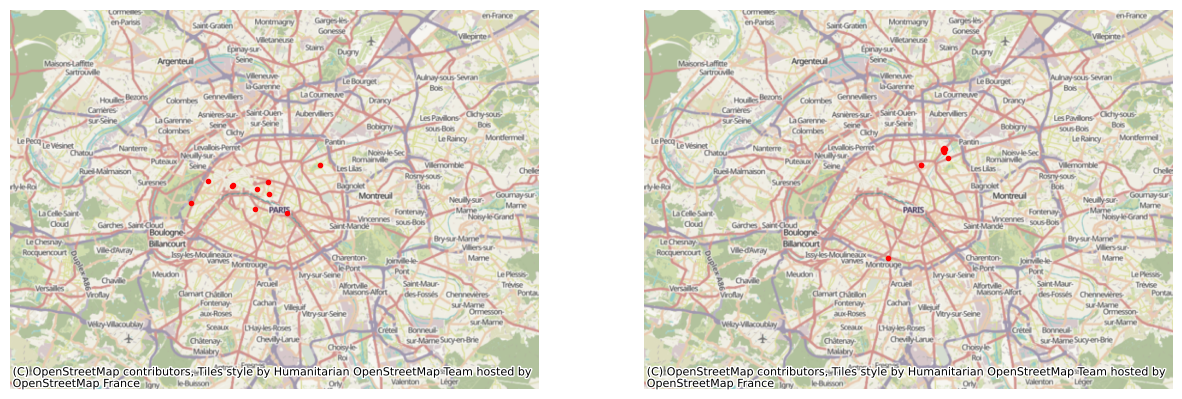

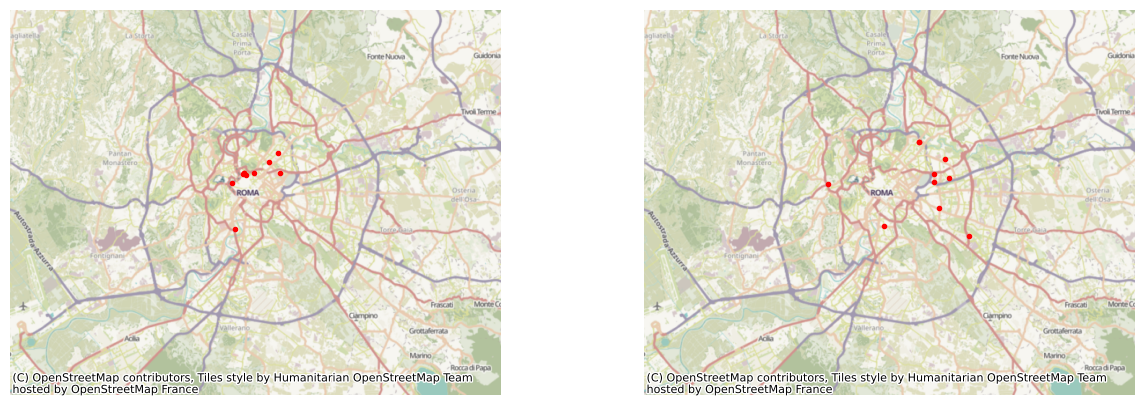

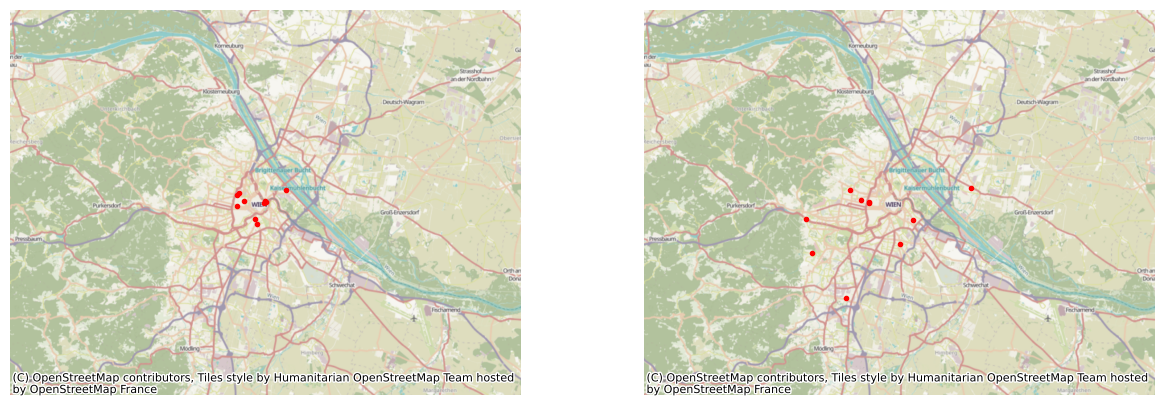

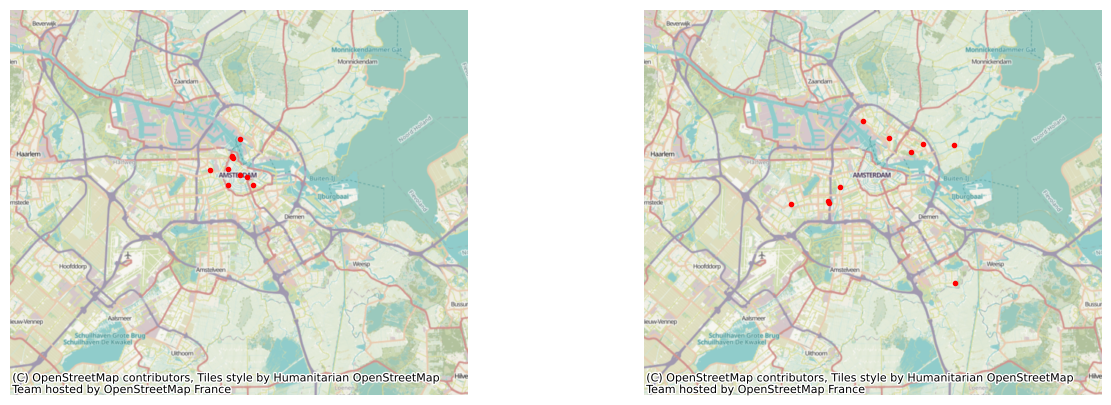

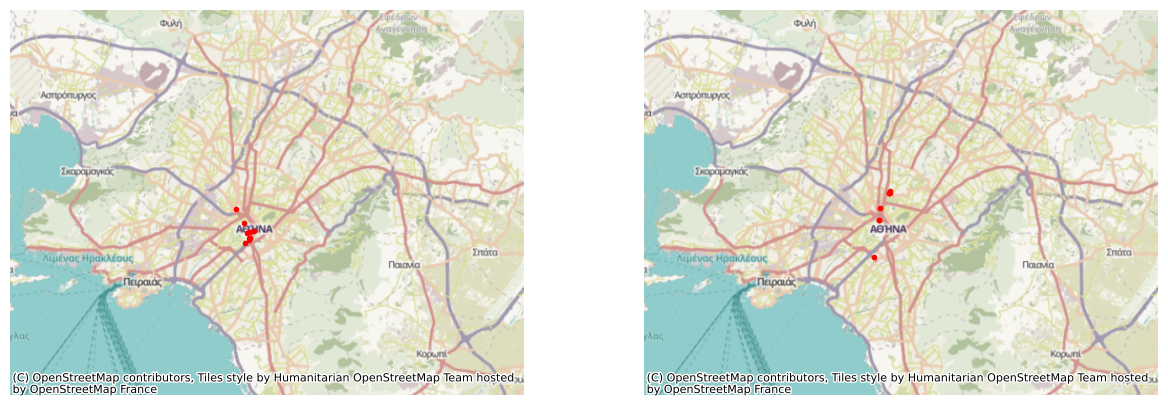

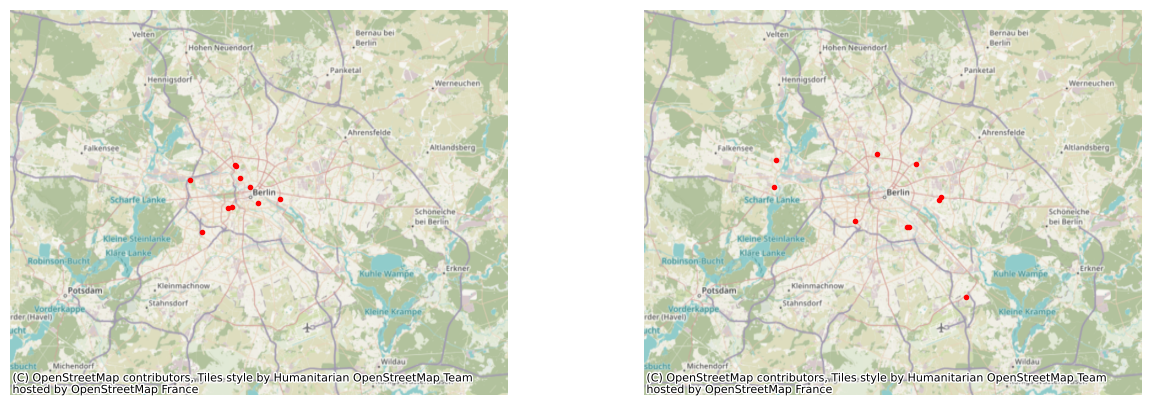

In [17]:
#Function creates two maps in which the ten most expensive and least expensive airbnbs of a city are displayed
def createCityMapMaxMinPrice(city_name):
    
    # Filter the data for a single city
    city_gdf = gdf[gdf["city"].str.contains(city_name, case = False, na=False)]
    #Filter out only weeekend data to avoid double representation of the same offer
    we_city_gdf = city_gdf[city_gdf["week_category"] == "weekends"]
    #Find out longitude and latidute boundaries of the geodataframe to set boundaries of the map accordingly
    lngs = [we_city_gdf["lng"].min()-0.16 , we_city_gdf["lng"].max() +0.16]
    lats = [we_city_gdf["lat"].min()-0.08 , we_city_gdf["lat"].max() +0.08]
    # Create the plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    we_city_gdf.nlargest(10, "price").plot(ax=axes[0], color="red", markersize=9)
    axes[0].set_xlim(lngs)  # Longitude limits
    axes[0].set_ylim(lats)  # Latitude limits
    axes[0].set_axis_off()
    # Add basemap
    cx.add_basemap(axes[0], crs="EPSG:4258")
    we_city_gdf.nsmallest(10, "price").plot(ax=axes[1], color="red", markersize=9)
    axes[1].set_xlim(lngs)  # Longitude limits
    axes[1].set_ylim(lats)  # Latitude limits
    axes[1].set_axis_off()
    # Add basemap
    cx.add_basemap(axes[1], crs="EPSG:4258")
    plt.show()
#Call the function once for each city
for key in cities:
    createCityMapMaxMinPrice(key)

           price        room_type  person_capacity  host_is_superhost  \
15563  34.779339     Private room                2              False   
13884  37.129295  Entire home/apt                2              False   
13954  39.009259     Private room                3              False   
15917  40.184236     Private room                3              False   
3948   42.884259     Private room                3              False   

       cleanliness_rating  guest_satisfaction_overall  bedrooms      dist  \
15563                  10                          97         1  9.986018   
13884                  10                          93         2  4.644683   
13954                   9                          90         3  8.014301   
15917                   9                          90         3  8.014306   
3948                    9                          93         1  1.553455   

       metro_dist  attr_index  attr_index_norm  rest_index  rest_index_norm  \
15563    7.847268  

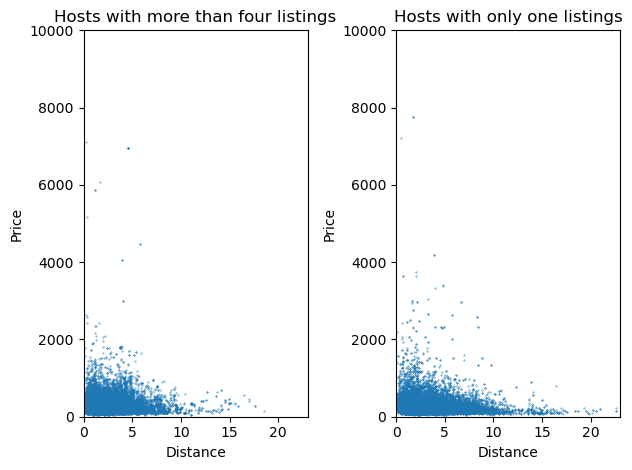

In [6]:
#Bonus question: Gentrification in city centers
#Check minimum price per night of all airbnbs
print(df.nsmallest(5, "price"))

biz_df = df[df["listings"] == "more_than_4"]
sgl_df = df[df["listings"] == "1"]
biz_df = df[df["listings"] == "more_than_4"]
sgl_df = df[df["listings"] == "1"]

# Create subplots
fig, axes = plt.subplots(1, 2)

# Scatter plot for biz_df
axes[0].scatter(biz_df["dist"], biz_df["price"], s=0.1)
axes[0].set_title("Hosts with more than four listings")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Price")
axes[0].set_xlim(0,23)
axes[0].set_ylim(0,10000)

# Scatter plot for sgl_df
axes[1].scatter(sgl_df["dist"], sgl_df["price"], s=0.1)
axes[1].set_title("Hosts with only one listings")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Price")
axes[1].set_xlim(0,23)
axes[1].set_ylim(0,10000)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
#Look for correlation between owners with more appartments and distance/price
from scipy import stats
grouped = [df[df["listings"] == cat]["dist"] for cat in df["listings"].unique()]
# Perform Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(*grouped)
print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

H-statistic: 1708.9255572565016
P-value: 0.0


In [16]:
grouped = [df[df["listings"] == cat]["price"] for cat in df["listings"].unique()]
# Perform Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(*grouped)
print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

H-statistic: 521.4605386170465
P-value: 5.838251158299328e-114
